# Obtain the angle resolved grain maps of PARADIM-1

In [2]:
%run -i ../tomography/utils.py
%run -i startup3.py

## Shadow method

### Load and reformat the data

In [5]:
sel_row = df_uid.loc[6]
sel_row

uid       b0203814-c252-4abe-9c44-692725298508
sample                               PARADIM-1
task           redo single point rocking curve
beam                                     focus
Name: 6, dtype: object

In [6]:
run = db_raw[sel_row['uid']]
data = reformat_data(run.xarray_dask())
image_data = data["dexela_image"]

In [7]:
data

<xarray.Dataset>
Dimensions:              (dim_0: 1, dim_1: 3888, dim_2: 3072, frame: 1001)
Coordinates:
  * frame                (frame) int64 0 1 2 3 4 5 ... 995 996 997 998 999 1000
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    dexela_stats1_total  (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dexela_image         (frame, dim_0, dim_1, dim_2) float64 dask.array<chunksize=(1, 1, 3888, 3072), meta=np.ndarray>
    mPhi                 (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    mPhi_user_setpoint   (frame) float64 dask.array<chunksize=(1,), meta=np.ndarray>

In [9]:
del sel_row

### Test the method

We iterate the images along the time series and find the maximum and minimum values on each pixel. The images of the maximum values are like a photo of all shadows of the Bragg peaks on the detector while the ones of the minimum values are like the record of the lowest background intensities on the images.

This method is implemented in `min_and_max_along_time`.

In [10]:
shadows = min_and_max_along_time(image_data)

In [12]:
db_cdf.insert(shadows.to_dataset(name="shadow"), dict(**run.start, tag="max and min frame"))

'60c912a12e5b85093184cbf4'

### Analyze the result

The method will catch the powder diffraction in it. We need to filter the images and only apply the method on the images of non-powder part.

In [24]:
shadows = db_cdf.get_data("60c912a12e5b85093184cbf4")["shadow"]

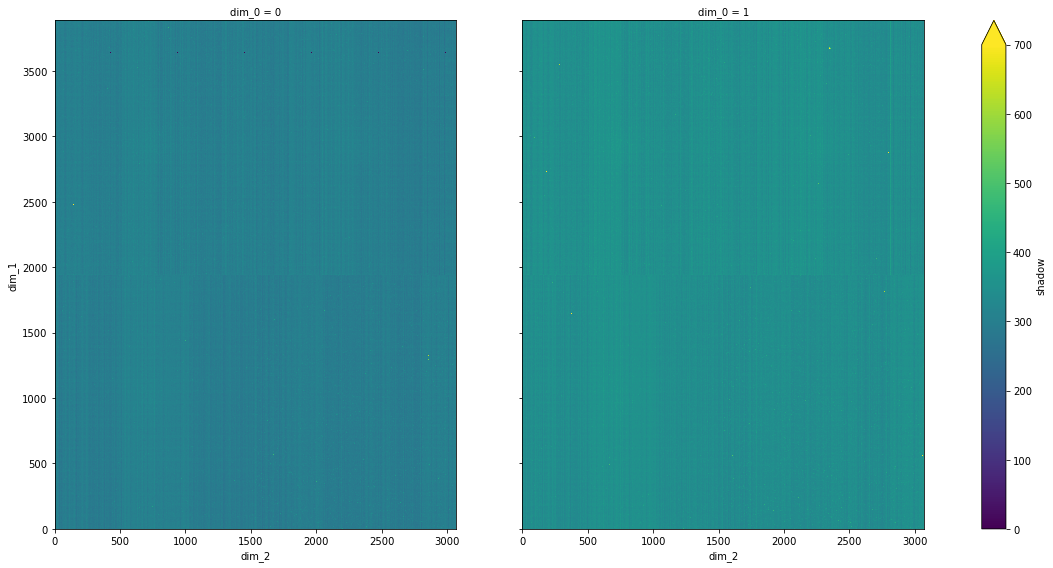

In [17]:
facet = shadows.plot(col="dim_0", vmax=700, size=8)
set_real_aspect(facet.axes)

The beam may be too weak. I didn't see large Bragg peaks on the detectors. All the shinning points are relatively smaller than those on the PARADIM-2's image.

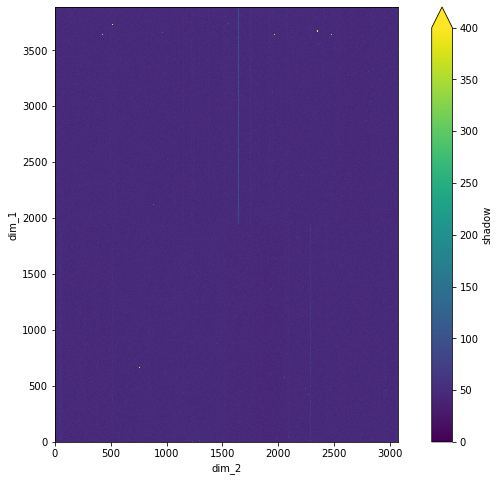

In [28]:
subtracted_shadow = shadows[1] - shadows[0]
facet = subtracted_shadow.plot(size=8, vmax=400)
set_real_aspect(facet.axes)

In [21]:
del shadows, facet

## Locate the peak positions and track it

### Locate the spots

Use `trackpy.locate` to find the spots on the image.

In [38]:
df = tp.locate(subtracted_shadow.values.astype(np.int16), diameter=35, percentile=67., engine="numba", threshold=100, minmass=200)
df

,y,x,mass,size,ecc,signal,raw_mass,ep
0,2236.998865,47.987917,15464.376142,1.324758,0.201622,2557.923047,59692.0,0.063862
1,2286.998784,1776.989362,15532.197177,1.326030,0.200538,2564.453378,59460.0,0.064739
2,3461.003257,61.992500,15631.411011,1.326374,0.201075,2578.064793,59753.0,0.063636
3,3673.708801,2349.090445,112258.761740,3.774932,0.091256,2084.434661,183101.0,0.007788


In [40]:
db_csv.update_data("60c918722e5b85093184cbf5", df)

In [30]:
del df

### Select the ones to track

We select the 20 largest peaks to track.

In [41]:
peaks = db_csv.get_data("60c918722e5b85093184cbf5")
windows = create_windows_from_width(peaks, 15)

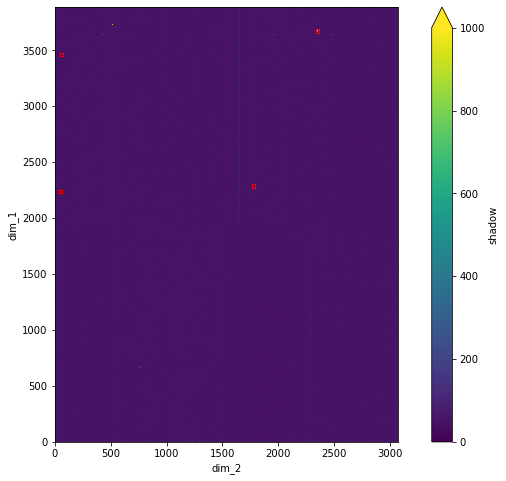

In [45]:
facet = subtracted_shadow.plot(size=8, vmax=1000)
set_real_aspect(facet.axes)
draw_windows(windows, facet.axes)

In [44]:
del peaks, facet

### Run the tracking

In [46]:
grains = create_grain_maps(image_data, windows, run.start)

In [47]:
db_cdf.insert(grains, dict(**run.start, tag="grain maps"))

'60c91eb02e5b85093184cbf6'

In [48]:
del grains

### Visualize the grain maps

The intensity is plotted as a function of rotation angle.

In [52]:
grains = db_cdf.get_data("60c91eb02e5b85093184cbf6")
grains = grains.set_index({"grain": ["x", "y"]})

In [53]:
grains["maps"].attrs["standard_name"] = "I"
grains["maps"].attrs["units"] = "A. U."
grains["dim_0"].attrs["standard_name"] = "θ"
grains["dim_0"].attrs["units"] = "deg"

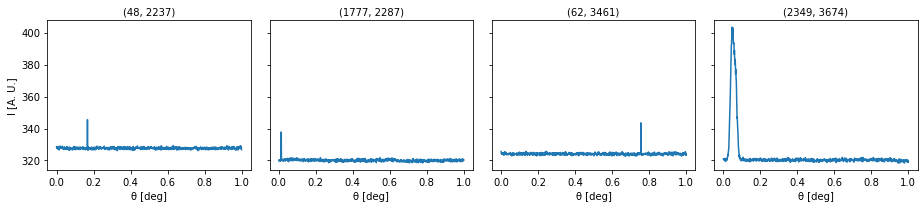

In [54]:
facet = grains["maps"].plot(col="grain")
facet.set_titles(template="{value}");

### The mean of the grain maps

It shows the total distribution of all 20 grains.

In [55]:
mean_map = grains["maps"].mean(axis=1)

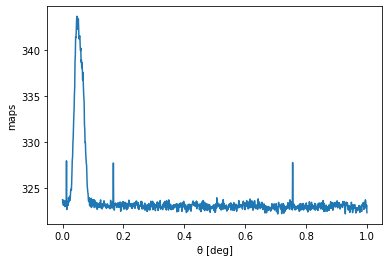

In [56]:
facet = mean_map.plot()